In [76]:
# This notebook provides examples on how to use the EnsembleTreeExplainer and EnsembleTreeExplainerTransformer in python

import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from transparency.python.explainer.ensemble_tree import EnsembleTreeExplainer, EnsembleTreeExplainerTransformer
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

0.4572378550220241
[('age', 4.868356164383563), ('sex', 2.8878082191780816), ('bmi', -1.0010273972602743), ('map', 14.186917808219178), ('tc', 1.7128767123287667), ('ldl', 6.031027397260274), ('hdl', 0.5033561643835619), ('tch', -3.4859589041095895), ('ltg', 1.9572602739726057), ('glu', 1.1881506849315062)]


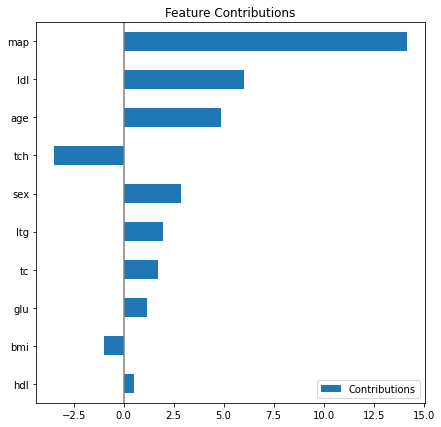

In [77]:
# EnsembleTreeExplainer Example

# loading the diabetes dataset
columns = 'age sex bmi map tc ldl hdl tch ltg glu'.split()
diabetes = load_diabetes()
X = np.array(pd.DataFrame(diabetes.data, columns=columns))
y = diabetes.target

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# model training
rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

# prediction explanation generation
expl = EnsembleTreeExplainer(rf_model)
contributions, contrib_intercept = expl.predict(X_test)
assert(((np.sum(contributions, axis=1) + contrib_intercept) - y_pred < .01).all())

average_contribs = list(zip(columns, np.mean(contributions, axis=0)))
print(average_contribs)

# Plotting mean feature contributions over the total population
plot_contrib_df = pd.DataFrame(np.mean(contributions, axis=0), index=columns, columns=['Contributions'])
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()

In [78]:
# XGBOOST EnsembleTreeExplainer Example

# model training
xgb_model = XGBRegressor().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

# prediction explanation generation
expl = EnsembleTreeExplainer(xgb_model)
contributions, contrib_intercept = expl.predict(X_test)
assert(((np.sum(contributions, axis=1) + contrib_intercept) - y_pred < .01).all())

average_contribs = zip(columns, np.mean(contributions, axis=0))
print(list(average_contribs))

0.3860805298927019
[('age', 3.9977496), ('sex', 12.185576), ('bmi', -10.831456), ('map', 0.23791292), ('tc', -6.3151193), ('ldl', -10.828937), ('hdl', 9.372715), ('tch', 0.85178983), ('ltg', 5.905974), ('glu', 1.2700697)]


In [79]:
# Explanation Using the Ensemble Tree Explanation Transformer

# model training
rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

X_test2 = pd.DataFrame(X_test)

expl = EnsembleTreeExplainerTransformer(rf_model)
expl.fit()
X_test2 = expl.transform(X_test2)

assert('feature_contributions' in X_test2.columns)
assert('intercept_contribution' in X_test2.columns)
assert((np.abs(np.array(X_test2['feature_contributions'].apply(lambda x: sum(x[0])) + \
                        X_test2['intercept_contribution']) - np.array(y_pred)) < .01).all())

0.4481169077091779


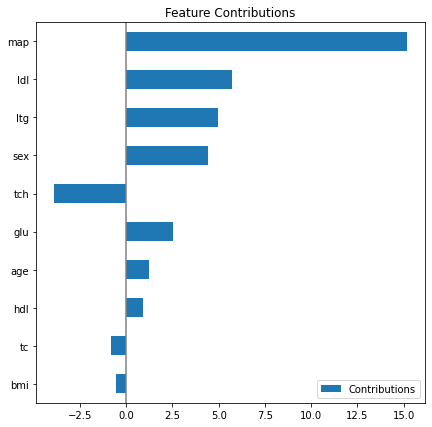

In [80]:
# Plotting mean feature contributions over the total population
plot_contrib_df = pd.DataFrame(np.mean(X_test2['feature_contributions'].apply(lambda x: x[0]), axis=0),
                               index=columns, columns=['Contributions'])

final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()
